In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
from sklearn.metrics import roc_auc_score

cc_codes = [
    "ka", "lv", "ta", "ur", "eo", "lt", "sl", "hy", "hr", "sk", "eu", "et", "ms", "az", "da", "bg",
    "sr", "ro", "el", "th", "bn", "no", "hi", "ca", "hu", "ko", "fi", "vi", "uz", "sv", "cs", "he",
    "id", "tr", "uk", "nl", "pl", "ar", "fa", "it", "zh", "ru", "es", "ja", "de", "fr", "en"
]
filename_pattern_test = "../data/processed_test_full_{}.csv".format("_".join(cc_codes))

test_df = pd.read_csv(filename_pattern_test)

with open('../data/additional_features.pickle', 'rb') as handle:
    additional_features_dict = pickle.load(handle)
    
def get_additional_features(df, dict_):

    additional_features_list = []
    for r, db in tqdm(zip(df.revision_id.values, df.wiki_db.values)):
        additional_features_list.append(dict_.get((db, r), {}))
    additional_features_df = pd.DataFrame(additional_features_list)
    return pd.concat([df.reset_index(drop=True), additional_features_df], axis=1)
test_df = get_additional_features(test_df, additional_features_dict)

1079265it [00:01, 932225.24it/s]


In [11]:
test_df.head(2)

,wiki_db,event_comment,event_user_text_historical,event_user_seconds_since_previous_revision,revision_id,page_title,page_revision_count,revision_text_bytes_diff,revision_is_identity_reverted,event_timestamp,...,is_bureaucrat,is_autopatrolled,is_patroller,is_rollbacker,is_reviewer,is_extendedconfirmed,is_templateeditor,is_uploader,is_autoreviewer,is_suppressredirect
0,kawiki,/* ისტორია */,M.,11654.0,4392381,მცხეთა,189,1288,0,2022-07-05 15:35:50.0,...,False,False,False,False,False,False,False,False,False,False
1,kawiki,NaN,David1010,379.0,4390597,საქართველოს მმართველთა სია,911,-1149,0,2022-07-01 08:47:55.0,...,True,False,False,False,False,False,False,False,False,False


In [32]:
len(test_df)

1079265

## Calculating balance test-set

In [3]:
def get_balanced(df):
    # creating balanced dataset (balancing the label + across the languages)
    random_seed = 42
    dfs = []
    for cc in tqdm(df.wiki_db.unique()):
        test_df_cc = df[df.wiki_db == cc]
        test_df_cc_0 = test_df_cc[test_df_cc.revision_is_identity_reverted == 0]
        test_df_cc_1 = test_df_cc[test_df_cc.revision_is_identity_reverted == 1]
        positive_len = len(test_df_cc_1)
        test_df_cc_0_sample = test_df_cc_0.sample(positive_len, random_state=random_seed)
        dfs.append(test_df_cc_0_sample)
        dfs.append(test_df_cc_1)

    test_df_balanced = pd.concat(dfs)
    print(len(test_df_balanced))
    return test_df_balanced


def get_balanced_anon(df):
    # creating balanced dataset (balancing the label + across the languages)
    random_seed = 42
    dfs = []
    for cc in tqdm(df.wiki_db.unique()):
        test_df_cc = df[(df.wiki_db == cc) & (test_df.is_anonymous == 1)]
        test_df_cc_0 = test_df_cc[test_df_cc.revision_is_identity_reverted == 0]
        test_df_cc_1 = test_df_cc[test_df_cc.revision_is_identity_reverted == 1]
        positive_len = len(test_df_cc_1)
        negative_len = len(test_df_cc_0)
        if positive_len <= negative_len:
            test_df_cc_0_sample = test_df_cc_0.sample(positive_len, random_state=random_seed)
            test_df_cc_1_sample = test_df_cc_1
        else:
            test_df_cc_1_sample = test_df_cc_1.sample(negative_len, random_state=random_seed)
            test_df_cc_0_sample = test_df_cc_0

        dfs.append(test_df_cc_0_sample)
        dfs.append(test_df_cc_1_sample)

    test_df_balanced = pd.concat(dfs)
    print(len(test_df_balanced))
    return test_df_balanced

In [4]:
# revert rate:
test_df.revision_is_identity_reverted.mean()

0.06943614404247335

In [5]:
test_df_balanced = get_balanced(test_df)

100%|██████████| 47/47 [00:06<00:00,  6.96it/s]


149880


## Calculate test statistics:

In [6]:
(test_df.remove_p_1_mean != -1).mean()

0.1440443264629169

In [7]:
(test_df.change_p_1_mean != -1).mean()

0.38436157940820836

In [8]:
(test_df.insert_p_1_mean != -1).mean()

0.24318494531000265

In [9]:
((test_df.remove_p_1_mean != -1) | (test_df.change_p_1_mean != -1) | (test_df.insert_p_1_mean != -1)).mean()

0.5564027370478983

## Calculating text_models_metrics

#### All users:

In [12]:
test_with_changes = test_df[test_df.change_p_1_mean != -1]
roc_auc_score(test_with_changes.revision_is_identity_reverted, test_with_changes.change_p_1_mean)

0.7248274327515863

In [13]:
test_with_inserts = test_df[test_df.insert_p_1_mean != -1]
roc_auc_score(test_with_inserts.revision_is_identity_reverted, test_with_inserts.insert_p_1_mean)

0.7157430461967972

In [14]:
test_with_removes = test_df[test_df.remove_p_1_mean != -1]
roc_auc_score(test_with_removes.revision_is_identity_reverted, test_with_removes.remove_p_1_mean)

0.625436345488924

#### Anonymous users:

In [15]:
test_df_balanced = get_balanced_anon(test_df)

100%|██████████| 47/47 [00:03<00:00, 12.41it/s]


98454


In [19]:
test_with_changes = test_df[(test_df.change_p_1_mean != -1) & (test_df.is_anonymous == 1)]
roc_auc_score(test_with_changes.revision_is_identity_reverted, test_with_changes.change_p_1_mean)

0.7573636405773874

In [20]:
test_with_inserts = test_df[(test_df.insert_p_1_mean != -1) & (test_df.is_anonymous == 1)]
roc_auc_score(test_with_inserts.revision_is_identity_reverted, test_with_inserts.insert_p_1_mean)

0.7521872087475855

In [21]:
test_with_removes = test_df[(test_df.remove_p_1_mean != -1) & (test_df.is_anonymous == 1)]
roc_auc_score(test_with_removes.revision_is_identity_reverted, test_with_removes.remove_p_1_mean)

0.681027864026895

# Calculating final models metrics:

### ORES:

In [39]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve

def precision_at_recall(y_true, y_scores, recall_thr=0.75):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    idx = np.where(recall > recall_thr)[0][-1]
    return precision[idx]

test_df_balanced = get_balanced(test_df)
ores_model_res = pd.read_csv("../data/test_ores_scores_full_test.csv")
ores_model_res_dict = {rid: score for rid, score in zip(ores_model_res.revision_id, ores_model_res.ores_pred)}

test_df_balanced["ores_pred"] = test_df_balanced.revision_id.apply(lambda x: ores_model_res_dict.get(x)).fillna(-1)

## filtering only existing scores:
df_to_plot = test_df_balanced[test_df_balanced.ores_pred != -1]

threshold = 0.5
print("ORES model accuracy: ", ((df_to_plot.ores_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("ORES model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred))
print("ORES model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold))
print("ORES model Precision: ", precision_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold))
print("ORES model Recall: ", recall_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold))
print("ORES model PR@R0.75: ", precision_at_recall(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred))

ores_metrics_all = {
    "model_name": "ORES",
    "accuracy": ((df_to_plot.ores_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean(),
    "AUC": roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred),
   "F1": f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold),
    "Precision": precision_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold),
   "Recall": recall_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold),
   "PR@R0.75": precision_at_recall(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred),
    }

100%|██████████| 47/47 [00:05<00:00,  9.19it/s]


149880
ORES model accuracy:  0.7091896912688349
ORES model AUC:  0.8164192464052575
ORES model F1:  0.6539895273263107
ORES model Precision:  0.8114796917852946
ORES model Recall:  0.5476942514213519
ORES model PR@R0.75:  0.7557660991857883


In [40]:
test_df_balanced = get_balanced_anon(test_df)

100%|██████████| 47/47 [00:03<00:00, 12.11it/s]


98454


In [41]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

ores_model_res = pd.read_csv("../data/test_ores_scores_full_test.csv")
ores_model_res_dict = {rid: score for rid, score in zip(ores_model_res.revision_id, ores_model_res.ores_pred)}

test_df_balanced["ores_pred"] = test_df_balanced.revision_id.apply(lambda x: ores_model_res_dict.get(x)).fillna(-1)

## filtering only existing scores:
df_to_plot = test_df_balanced[test_df_balanced.ores_pred != -1]

threshold = 0.5
print("ORES model accuracy: ", ((df_to_plot.ores_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("ORES model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred))
print("ORES model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold))
print("ORES model Precision: ", precision_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold))
print("ORES model Recall: ", recall_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold))
print("ORES model PR@R0.75: ", precision_at_recall(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred))

ores_metrics_anon = {
    "model_name": "ORES",
    "accuracy": ((df_to_plot.ores_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean(),
    "AUC": roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred),
   "F1": f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold),
    "Precision": precision_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold),
   "Recall": recall_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold),
   "PR@R0.75": precision_at_recall(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred),
    }

ORES model accuracy:  0.5724430713150555
ORES model AUC:  0.6382372652943584
ORES model F1:  0.6280742459396751
ORES model Precision:  0.5559282584884995
ORES model Recall:  0.721738357625311
ORES model PR@R0.75:  0.5511706886980374


### Baseline

In [42]:
test_df_balanced = get_balanced(test_df)
test_df_balanced["model_pred"] = test_df_balanced.is_anonymous
test_df_balanced["ores_pred"] = test_df_balanced.revision_id.apply(lambda x: ores_model_res_dict.get(x)).fillna(-1)

print("All users")
## filtering only existing scores:
df_to_plot = test_df_balanced[test_df_balanced.ores_pred != -1]
threshold = 0.5
print("Baseline model accuracy: ", ((df_to_plot.model_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("Baseline model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred))
print("Baseline model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred > threshold))
print("Baseline model Precision: ", precision_score(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred > threshold))
print("Baseline model Recall: ", recall_score(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred > threshold))
print("Baseline model PR@R0.75: ", precision_at_recall(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred))

baseline_metrics_all = {
    "model_name": "baseline",
    "accuracy": ((df_to_plot.model_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean(),
    "AUC": roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred),
   "F1": f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred > threshold),
    "Precision": precision_score(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred > threshold),
   "Recall": recall_score(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred > threshold),
   "PR@R0.75": precision_at_recall(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred),
    }

print()
print("ANON users")
test_df_balanced = get_balanced_anon(test_df)
test_df_balanced["ores_pred"] = test_df_balanced.revision_id.apply(lambda x: ores_model_res_dict.get(x)).fillna(-1)
test_df_balanced["model_pred"] = test_df_balanced.is_anonymous
df_to_plot = test_df_balanced[test_df_balanced.ores_pred != -1]
threshold = 0.5
print("Baseline model accuracy: ", ((df_to_plot.model_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("Baseline model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred))
print("Baseline model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred > threshold))
print("Baseline model Precision: ", precision_score(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred > threshold))
print("Baseline model Recall: ", recall_score(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred > threshold))
print("Baseline model PR@R0.57: ", precision_at_recall(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred))

baseline_metrics_anon = {
    "model_name": "baseline",
    "accuracy": ((df_to_plot.model_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean(),
    "AUC": roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred),
   "F1": f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred > threshold),
    "Precision": precision_score(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred > threshold),
   "Recall": recall_score(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred > threshold),
   "PR@R0.75": precision_at_recall(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred),
    }

100%|██████████| 47/47 [00:05<00:00,  8.55it/s]


149880
All users
Baseline model accuracy:  0.7432253118273229
Baseline model AUC:  0.7435096875541787
Baseline model F1:  0.7218913178863996
Baseline model Precision:  0.7906500865732725
Baseline model Recall:  0.6641349219174661
Baseline model PR@R0.75:  0.5017913484504467

ANON users


100%|██████████| 47/47 [00:03<00:00, 11.95it/s]


98454
Baseline model accuracy:  0.500194485502495
Baseline model AUC:  0.5
Baseline model F1:  0.6668395202572062
Baseline model Precision:  0.500194485502495
Baseline model Recall:  1.0
Baseline model PR@R0.57:  0.500194485502495


### ML models evaluation

In [43]:
def get_model_metrics(name):
    # name = "classifier_ml_all_non_balanced_user_features"
    threshold = 0.5
    print(name)
    # print("ALL")

    test_df_balanced = get_balanced(test_df)

    ml_model_res = pd.read_csv(f"../data/scores/{name}_scores.csv")
    ml_model_res_dict = {rid: score for rid, score in zip(ml_model_res.revision_id, ml_model_res.predict_score)}
    test_df_balanced["ml_pred"] = test_df_balanced.revision_id.apply(lambda x: ml_model_res_dict.get(x)).fillna(-1)
    test_df_balanced["ores_pred"] = test_df_balanced.revision_id.apply(lambda x: ores_model_res_dict.get(x)).fillna(-1)
    df_to_plot = test_df_balanced[test_df_balanced.ores_pred != -1]

    # print("ML model accuracy: ", ((df_to_plot.ml_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
    # print("ML model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred))
    # print("ML model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred > threshold))
    # print("ML model Precision: ", precision_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred > threshold))
    # print("ML model Recall: ", recall_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred > threshold))
    # print("ML model PR@R0.75: ", precision_at_recall(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred))
    
    all_metrics = {
           "model_name": name,
            "accuracy": ((df_to_plot.ml_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean(),
            "AUC": roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred),
           "F1": f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred > threshold),
            "Precision": precision_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred > threshold),
           "Recall": recall_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred > threshold),
           "PR@R0.75": precision_at_recall(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred),
    }

    # print()
    # print("ANON")
    test_df_balanced = get_balanced_anon(test_df)

    ml_model_res = pd.read_csv(f"../data/scores/{name}_scores.csv")
    ml_model_res_dict = {rid: score for rid, score in zip(ml_model_res.revision_id, ml_model_res.predict_score)}
    test_df_balanced["ml_pred"] = test_df_balanced.revision_id.apply(lambda x: ml_model_res_dict.get(x)).fillna(-1)
    test_df_balanced["ores_pred"] = test_df_balanced.revision_id.apply(lambda x: ores_model_res_dict.get(x)).fillna(-1)
    df_to_plot = test_df_balanced[test_df_balanced.ores_pred != -1]

    # print("ML model accuracy: ", ((df_to_plot.ml_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
    # print("ML model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred))
    # print("ML model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred > threshold))
    # print("ML model Precision: ", precision_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred > threshold))
    # print("ML model Recall: ", recall_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred > threshold))
    # print("ML model PR@R0.75: ", precision_at_recall(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred))
    
    anon_metrics = {
            "model_name": name,
            "accuracy": ((df_to_plot.ml_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean(),
            "AUC": roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred),
            "F1": f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred > threshold),
            "Precision": precision_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred > threshold),
            "Recall": recall_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred > threshold),
            "PR@R0.75": precision_at_recall(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred),
    }
    
    return all_metrics, anon_metrics
    

In [44]:
name = "classifier_ml_all_non_balanced_user_features"
get_model_metrics(name)

classifier_ml_all_non_balanced_user_features


100%|██████████| 47/47 [00:05<00:00,  9.02it/s]


149880


100%|██████████| 47/47 [00:04<00:00, 11.07it/s]


98454


({'model_name': 'classifier_ml_all_non_balanced_user_features',
  'accuracy': 0.7700439359537641,
  'AUC': 0.8322419013733405,
  'F1': 0.7792262941101533,
  'Precision': 0.7517924206213725,
  'Recall': 0.8087381921285755,
  'PR@R0.75': 0.7833604369304409},
 {'model_name': 'classifier_ml_all_non_balanced_user_features',
  'accuracy': 0.5139418321645681,
  'AUC': 0.6088833702717977,
  'F1': 0.6690728045883083,
  'Precision': 0.507297427542052,
  'Recall': 0.9823364735158194,
  'PR@R0.75': 0.5575833649891819})

In [45]:
model_names = [
    "classifier_ml_anon_non_balanced_new",
    "classifier_ml_anon_non_balanced_mlm_new",
    "classifier_ml_all_non_balanced_new",
    "classifier_ml_all_non_balanced_user_features_new",
    "classifier_ml_all_non_balanced_mlm_new",
    "classifier_ml_all_non_balanced_user_features_mlm_new",
]

anon_metrics = [ores_metrics_anon, baseline_metrics_anon]
all_metrics = [ores_metrics_all, baseline_metrics_all]

for name in model_names:
    all_m, anon_m = get_model_metrics(name)
    anon_metrics.append(anon_m)
    all_metrics.append(all_m)


classifier_ml_anon_non_balanced_new


100%|██████████| 47/47 [00:05<00:00,  8.70it/s]


149880


100%|██████████| 47/47 [00:03<00:00, 12.34it/s]


98454
classifier_ml_anon_non_balanced_mlm_new


100%|██████████| 47/47 [00:05<00:00,  8.77it/s]


149880


100%|██████████| 47/47 [00:03<00:00, 12.31it/s]


98454
classifier_ml_all_non_balanced_new


100%|██████████| 47/47 [00:04<00:00,  9.52it/s]


149880


100%|██████████| 47/47 [00:04<00:00, 11.57it/s]


98454
classifier_ml_all_non_balanced_user_features_new


100%|██████████| 47/47 [00:05<00:00,  9.22it/s]


149880


100%|██████████| 47/47 [00:03<00:00, 12.45it/s]


98454
classifier_ml_all_non_balanced_mlm_new


100%|██████████| 47/47 [00:08<00:00,  5.52it/s]


149880


100%|██████████| 47/47 [00:03<00:00, 12.41it/s]


98454
classifier_ml_all_non_balanced_user_features_mlm_new


100%|██████████| 47/47 [00:04<00:00,  9.57it/s]


149880


100%|██████████| 47/47 [00:03<00:00, 11.76it/s]


98454


In [46]:
print("Anonymous users metrics")
pd.DataFrame(anon_metrics)[["model_name", "accuracy", "F1"]]

Anonymous users metrics


,model_name,accuracy,F1
0,ORES,0.572443,0.628074
1,baseline,0.500194,0.666840
2,classifier_ml_anon_non_balanced_new,0.629488,0.650436
3,classifier_ml_anon_non_balanced_mlm_new,0.670819,0.676468
4,classifier_ml_all_non_balanced_new,0.607573,0.682046
5,classifier_ml_all_non_balanced_user_features_new,0.530912,0.674647
6,classifier_ml_all_non_balanced_mlm_new,0.638768,0.697637
7,classifier_ml_all_non_balanced_user_features_m...,0.552806,0.682600


In [47]:
print("All users metrics")
pd.DataFrame(all_metrics)[["model_name", "accuracy", "F1"]]

All users metrics


,model_name,accuracy,F1
0,ORES,0.709190,0.653990
1,baseline,0.743225,0.721891
2,classifier_ml_anon_non_balanced_new,0.660403,0.645407
3,classifier_ml_anon_non_balanced_mlm_new,0.682939,0.659892
4,classifier_ml_all_non_balanced_new,0.712079,0.721227
5,classifier_ml_all_non_balanced_user_features_new,0.777320,0.783312
6,classifier_ml_all_non_balanced_mlm_new,0.729270,0.731831
7,classifier_ml_all_non_balanced_user_features_m...,0.783726,0.787199


## Non-balanced dataset metrics (AUC, PR@R0.75)

In [48]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve

def precision_at_recall(y_true, y_scores, recall_thr=0.75):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    idx = np.where(recall > recall_thr)[0][-1]
    return precision[idx]

test_df_balanced = test_df
ores_model_res = pd.read_csv("../data/test_ores_scores_full_test.csv")
ores_model_res_dict = {rid: score for rid, score in zip(ores_model_res.revision_id, ores_model_res.ores_pred)}
test_df_balanced["ores_pred"] = test_df_balanced.revision_id.apply(lambda x: ores_model_res_dict.get(x)).fillna(-1)
## filtering only existing scores:
df_to_plot = test_df_balanced[test_df_balanced.ores_pred != -1]
ores_metrics_all = {
    "model_name": "ORES",
    "accuracy": ((df_to_plot.ores_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean(),
    "AUC": roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred),
   "F1": f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold),
    "Precision": precision_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold),
   "Recall": recall_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold),
   "PR@R0.75": precision_at_recall(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred),
    }

test_df_balanced = test_df[test_df.is_anonymous==1]
ores_model_res = pd.read_csv("../data/test_ores_scores_full_test.csv")
ores_model_res_dict = {rid: score for rid, score in zip(ores_model_res.revision_id, ores_model_res.ores_pred)}
test_df_balanced["ores_pred"] = test_df_balanced.revision_id.apply(lambda x: ores_model_res_dict.get(x)).fillna(-1)

## filtering only existing scores:
df_to_plot = test_df_balanced[test_df_balanced.ores_pred != -1]
threshold = 0.5
ores_metrics_anon = {
    "model_name": "ORES",
    "accuracy": ((df_to_plot.ores_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean(),
    "AUC": roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred),
   "F1": f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold),
    "Precision": precision_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold),
   "Recall": recall_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold),
   "PR@R0.75": precision_at_recall(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred),
    }

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [49]:
test_df_balanced = test_df
test_df_balanced["model_pred"] = test_df_balanced.is_anonymous
test_df_balanced["ores_pred"] = test_df_balanced.revision_id.apply(lambda x: ores_model_res_dict.get(x)).fillna(-1)

print("All users")
## filtering only existing scores:
df_to_plot = test_df_balanced[test_df_balanced.ores_pred != -1]
baseline_metrics_all = {
    "model_name": "baseline",
    "accuracy": ((df_to_plot.model_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean(),
    "AUC": roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred),
   "F1": f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred > threshold),
    "Precision": precision_score(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred > threshold),
   "Recall": recall_score(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred > threshold),
   "PR@R0.75": precision_at_recall(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred),
    }

test_df_balanced = test_df[test_df.is_anonymous==1]
test_df_balanced["ores_pred"] = test_df_balanced.revision_id.apply(lambda x: ores_model_res_dict.get(x)).fillna(-1)
test_df_balanced["model_pred"] = test_df_balanced.is_anonymous
df_to_plot = test_df_balanced[test_df_balanced.ores_pred != -1]
threshold = 0.5

baseline_metrics_anon = {
    "model_name": "baseline",
    "accuracy": ((df_to_plot.model_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean(),
    "AUC": roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred),
   "F1": f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred > threshold),
    "Precision": precision_score(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred > threshold),
   "Recall": recall_score(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred > threshold),
   "PR@R0.75": precision_at_recall(df_to_plot.revision_is_identity_reverted, df_to_plot.model_pred),
    }

All users


/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [50]:
def get_model_metrics(name):
    # name = "classifier_ml_all_non_balanced_user_features"
    threshold = 0.5
    print(name)

    test_df_balanced = test_df
    ml_model_res = pd.read_csv(f"../data/scores/{name}_scores.csv")
    ml_model_res_dict = {rid: score for rid, score in zip(ml_model_res.revision_id, ml_model_res.predict_score)}
    test_df_balanced["ml_pred"] = test_df_balanced.revision_id.apply(lambda x: ml_model_res_dict.get(x)).fillna(-1)
    test_df_balanced["ores_pred"] = test_df_balanced.revision_id.apply(lambda x: ores_model_res_dict.get(x)).fillna(-1)
    df_to_plot = test_df_balanced[test_df_balanced.ores_pred != -1]
    
    all_metrics = {
           "model_name": name,
           "accuracy": ((df_to_plot.ml_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean(),
           "AUC": roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred),
           "F1": f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred > threshold),
           "Precision": precision_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred > threshold),
           "Recall": recall_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred > threshold),
           "PR@R0.75": precision_at_recall(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred),
    }
    test_df_balanced = test_df[test_df.is_anonymous==1]
    ml_model_res = pd.read_csv(f"../data/scores/{name}_scores.csv")
    ml_model_res_dict = {rid: score for rid, score in zip(ml_model_res.revision_id, ml_model_res.predict_score)}
    test_df_balanced["ml_pred"] = test_df_balanced.revision_id.apply(lambda x: ml_model_res_dict.get(x)).fillna(-1)
    test_df_balanced["ores_pred"] = test_df_balanced.revision_id.apply(lambda x: ores_model_res_dict.get(x)).fillna(-1)
    df_to_plot = test_df_balanced[test_df_balanced.ores_pred != -1]
    
    anon_metrics = {
            "model_name": name,
            "accuracy": ((df_to_plot.ml_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean(),
            "AUC": roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred),
            "F1": f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred > threshold),
            "Precision": precision_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred > threshold),
            "Recall": recall_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred > threshold),
            "PR@R0.75": precision_at_recall(df_to_plot.revision_is_identity_reverted, df_to_plot.ml_pred),
    }
    
    return all_metrics, anon_metrics
    

In [54]:
model_names = [
    "classifier_ml_anon_non_balanced_new",
    "classifier_ml_anon_non_balanced_mlm_new",
    "classifier_ml_all_non_balanced_new",
    "classifier_ml_all_non_balanced_mlm_new",
    "classifier_ml_all_non_balanced_user_features_new",
    "classifier_ml_all_non_balanced_user_features_mlm_new",
]

anon_metrics = [ores_metrics_anon, baseline_metrics_anon]
all_metrics = [ores_metrics_all, baseline_metrics_all]

for name in model_names:
    all_m, anon_m = get_model_metrics(name)
    anon_metrics.append(anon_m)
    all_metrics.append(all_m)


classifier_ml_anon_non_balanced_new


/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


classifier_ml_anon_non_balanced_mlm_new


/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


classifier_ml_all_non_balanced_new


/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


classifier_ml_all_non_balanced_mlm_new


/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


classifier_ml_all_non_balanced_user_features_new


/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


classifier_ml_all_non_balanced_user_features_mlm_new


/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [55]:
print("Anonymous users metrics")
pd.DataFrame(anon_metrics)[["model_name", "AUC", "PR@R0.75"]]

Anonymous users metrics


,model_name,AUC,PR@R0.75
0,ORES,0.697275,0.305336
1,baseline,0.500000,0.237404
2,classifier_ml_anon_non_balanced_new,0.768056,0.396483
3,classifier_ml_anon_non_balanced_mlm_new,0.800966,0.438192
4,classifier_ml_all_non_balanced_new,0.751011,0.377947
5,classifier_ml_all_non_balanced_mlm_new,0.783998,0.416244
6,classifier_ml_all_non_balanced_user_features_new,0.761672,0.387028
7,classifier_ml_all_non_balanced_user_features_m...,0.792508,0.425928


In [56]:
print("All users metrics")
pd.DataFrame(all_metrics)[["model_name", "AUC", "PR@R0.75"]]

All users metrics


,model_name,AUC,PR@R0.75
0,ORES,0.839141,0.222693
1,baseline,0.750155,0.071316
2,classifier_ml_anon_non_balanced_new,0.770211,0.140642
3,classifier_ml_anon_non_balanced_mlm_new,0.791579,0.152349
4,classifier_ml_all_non_balanced_new,0.817125,0.182067
5,classifier_ml_all_non_balanced_mlm_new,0.837263,0.201049
6,classifier_ml_all_non_balanced_user_features_new,0.870204,0.267042
7,classifier_ml_all_non_balanced_user_features_m...,0.879507,0.282063


# Analyzing results per country (BAR plot + Scatterplots): 

In [74]:
model_names = [
    "ores",
    "classifier_ml_anon_non_balanced_new",
    "classifier_ml_anon_non_balanced_mlm_new",
    "classifier_ml_all_non_balanced_new",
    "classifier_ml_all_non_balanced_mlm_new",
    "classifier_ml_all_non_balanced_user_features_new",
    "classifier_ml_all_non_balanced_user_features_mlm_new",
]

NAMES = [
    "ORES",
    "Mult. Anonymous", 
    "Mult.Anonymous + MLM",
    "Mult. All",
    "Mult. All + MLM",
    "Mult. All + user feat.",
    "Mult. All + user feat. + MLM",
]

linestyles = [
    (0, (4, 1, 1, 1, 1, 1)),
    (0, (3, 1, 1, 1)),
    (0, (2, 1, 1, 1, 1, 1, 1, 1)),
    "dashdot", 
    "dashed",
    "dotted", 
    "solid",
]

# test_df_balanced = get_balanced(test_df)
test_df_balanced = test_df

test_df_balanced["ores_pred"] = test_df_balanced.revision_id.apply(lambda x: ores_model_res_dict.get(x)).fillna(-1)
test_df_balanced = test_df_balanced[test_df_balanced.ores_pred != -1]

for name in model_names[1:]:
    ml_model_res = pd.read_csv(f"../data/scores/{name}_scores.csv")
    ml_model_res_dict = {rid: score for rid, score in zip(ml_model_res.revision_id, ml_model_res.predict_score)}
    test_df_balanced[f"{name}_pred"] = test_df_balanced.revision_id.apply(lambda x: ml_model_res_dict.get(x)).fillna(-1)

# saving df for fairness metrics calculation:
columns_to_save = ["wiki_db", "revision_id", "revision_is_identity_reverted", "is_anonymous"] + [f"{name}_pred" for name in model_names]
test_df_balanced[columns_to_save].to_csv("../data/fairness_test.csv", index = False)

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


__________________________________________________


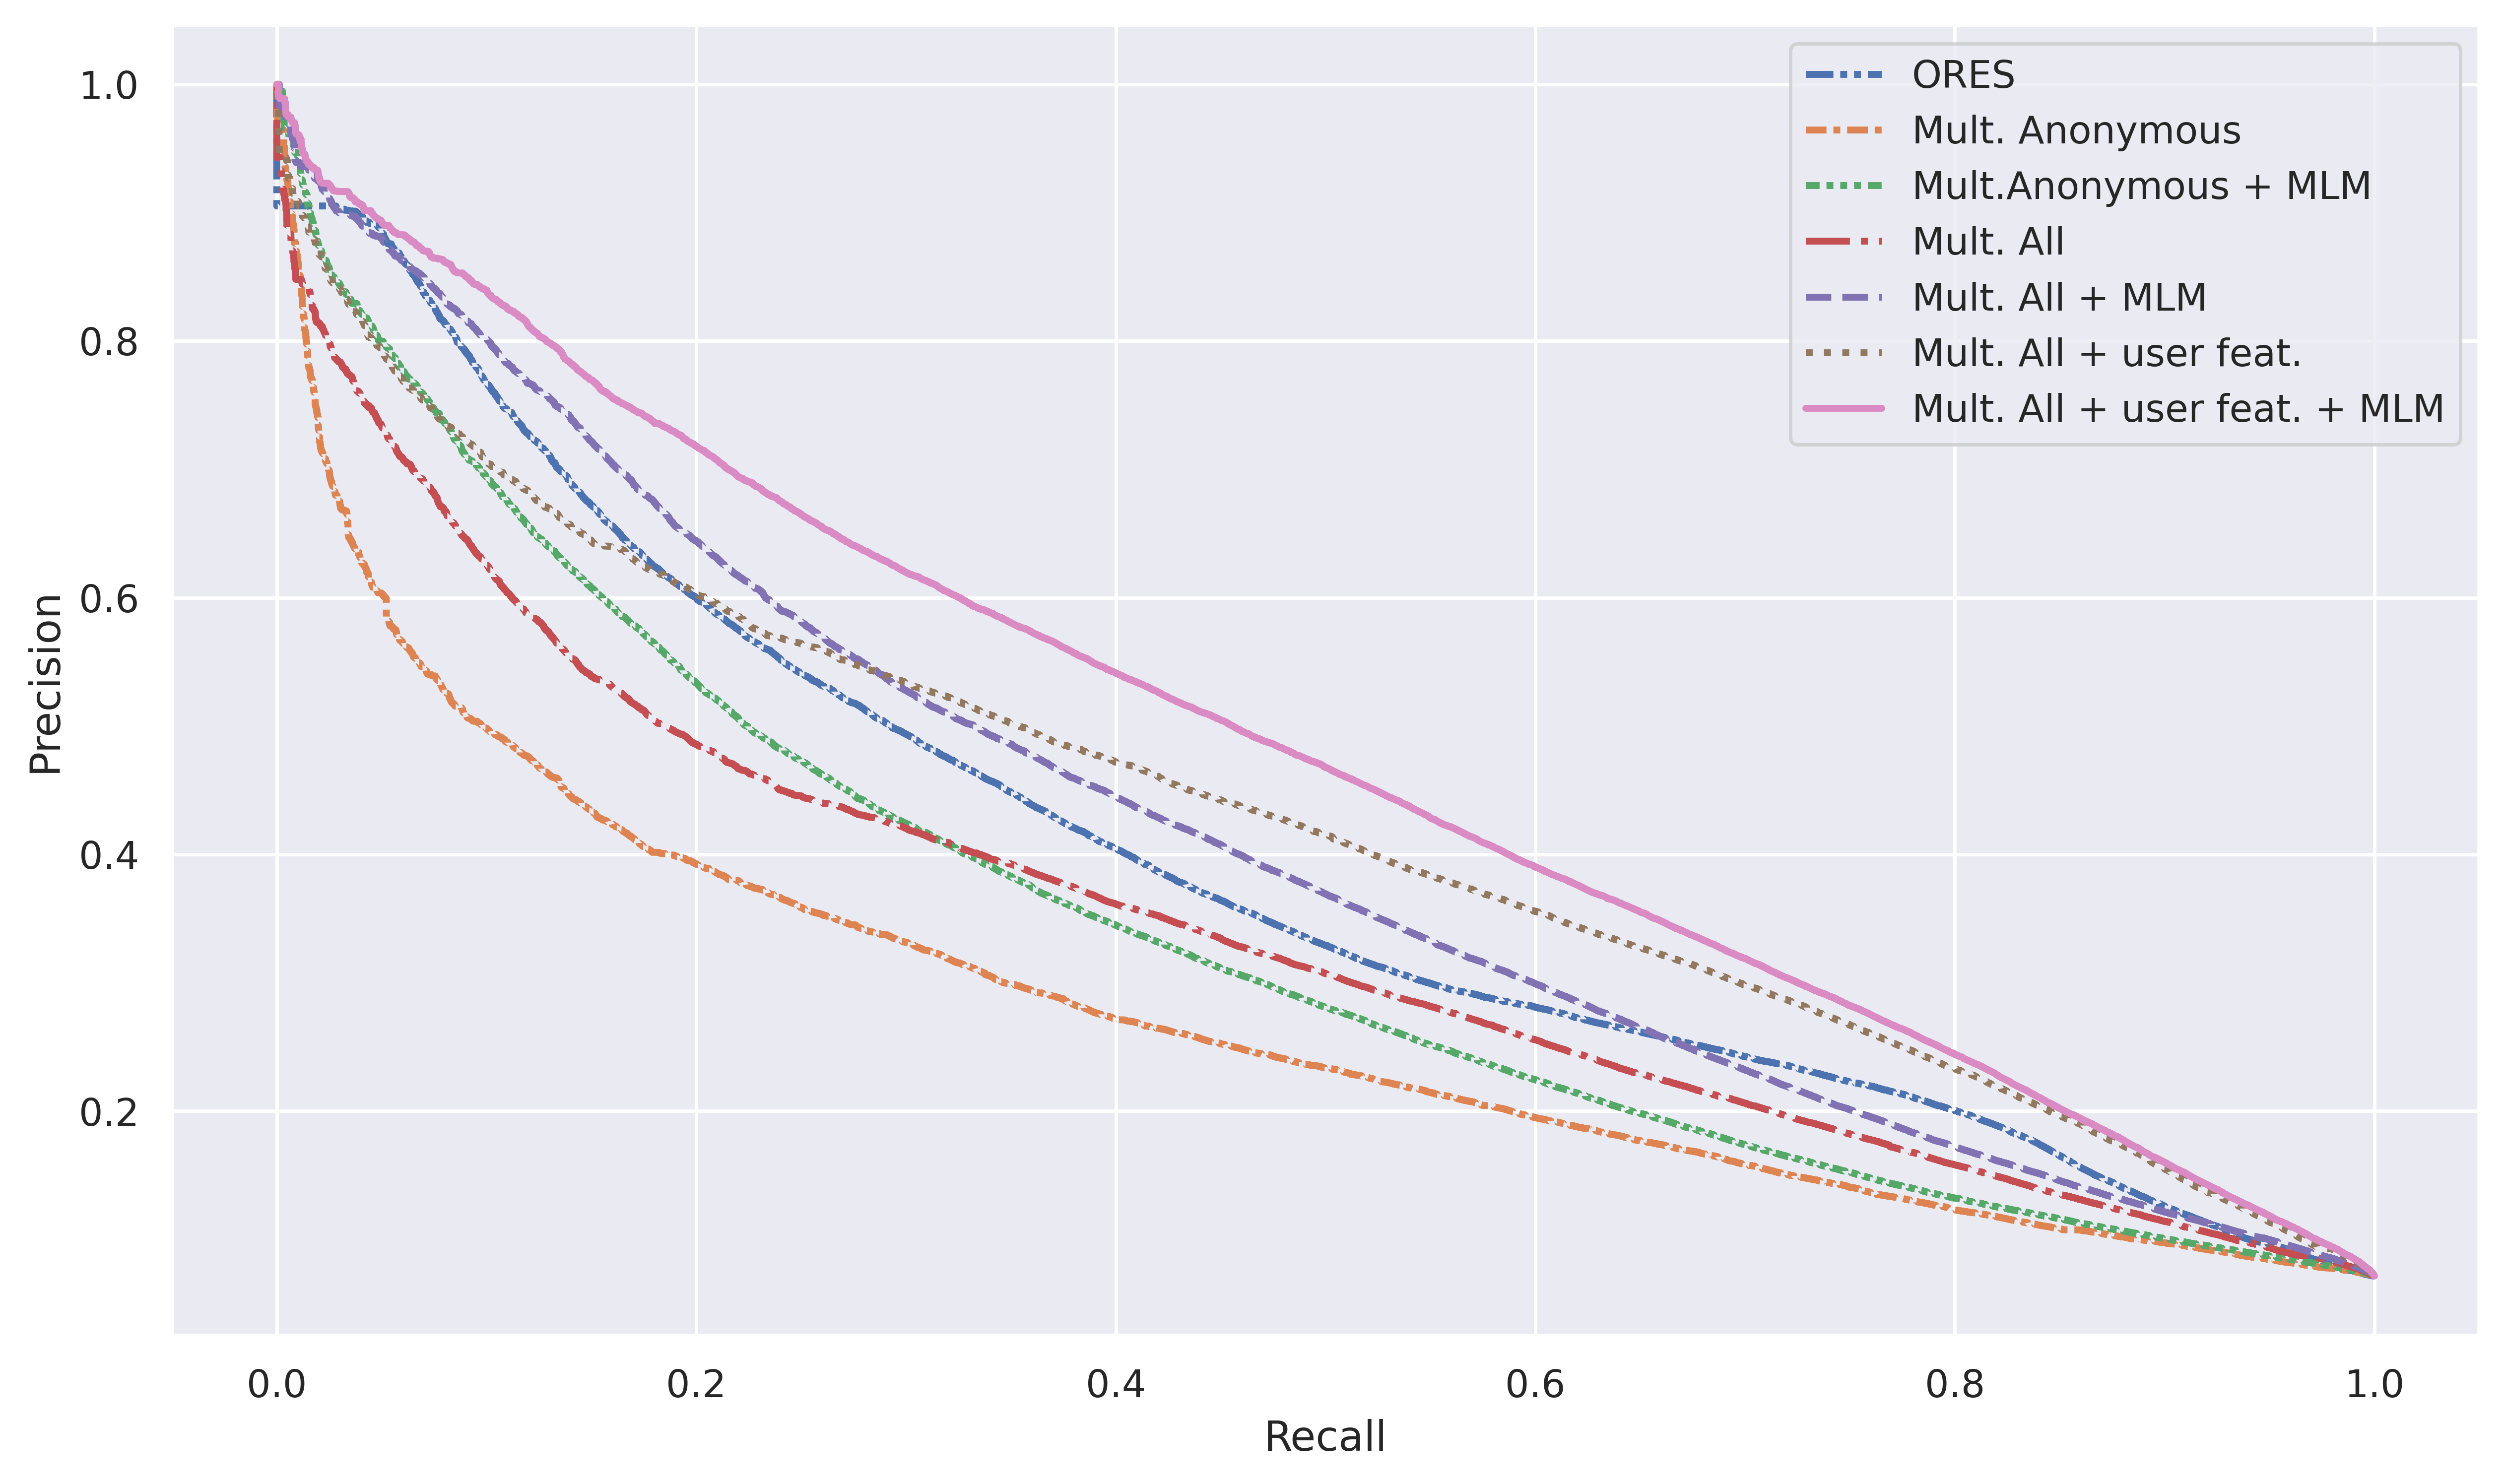

In [173]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

figure(figsize=(12, 7), dpi=500)

target_column = "revision_is_identity_reverted"

def precision_recall_plot(df_to_plot):
    true_values = df_to_plot[target_column].values
    def smooth_values(l):
        for i in range(1, len(l)):
            if l[i] < l[i-1]:
                l[i]=l[i-1]
        return l
    
    probs = [df_to_plot[f"{name}_pred"] for name in model_names]
    
    precisions, recalls = [], []
    for prob in probs:
        precision, recall, _ = precision_recall_curve(true_values, prob)
        precisions.append(smooth_values(precision))
        recalls.append(recall)

    print("_"*50)

    # plot the precision-recall curves
    no_skill = len(true_values[true_values==1]) / len(true_values)
    # pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    for p, r, n, linestyle in zip(precisions, recalls, NAMES, linestyles):
        pyplot.plot(r, p, linestyle=linestyle, linewidth=2, label=n)
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.savefig('pr_plot.png', dpi=500)

precision_recall_plot(test_df_balanced)

__________________________________________________


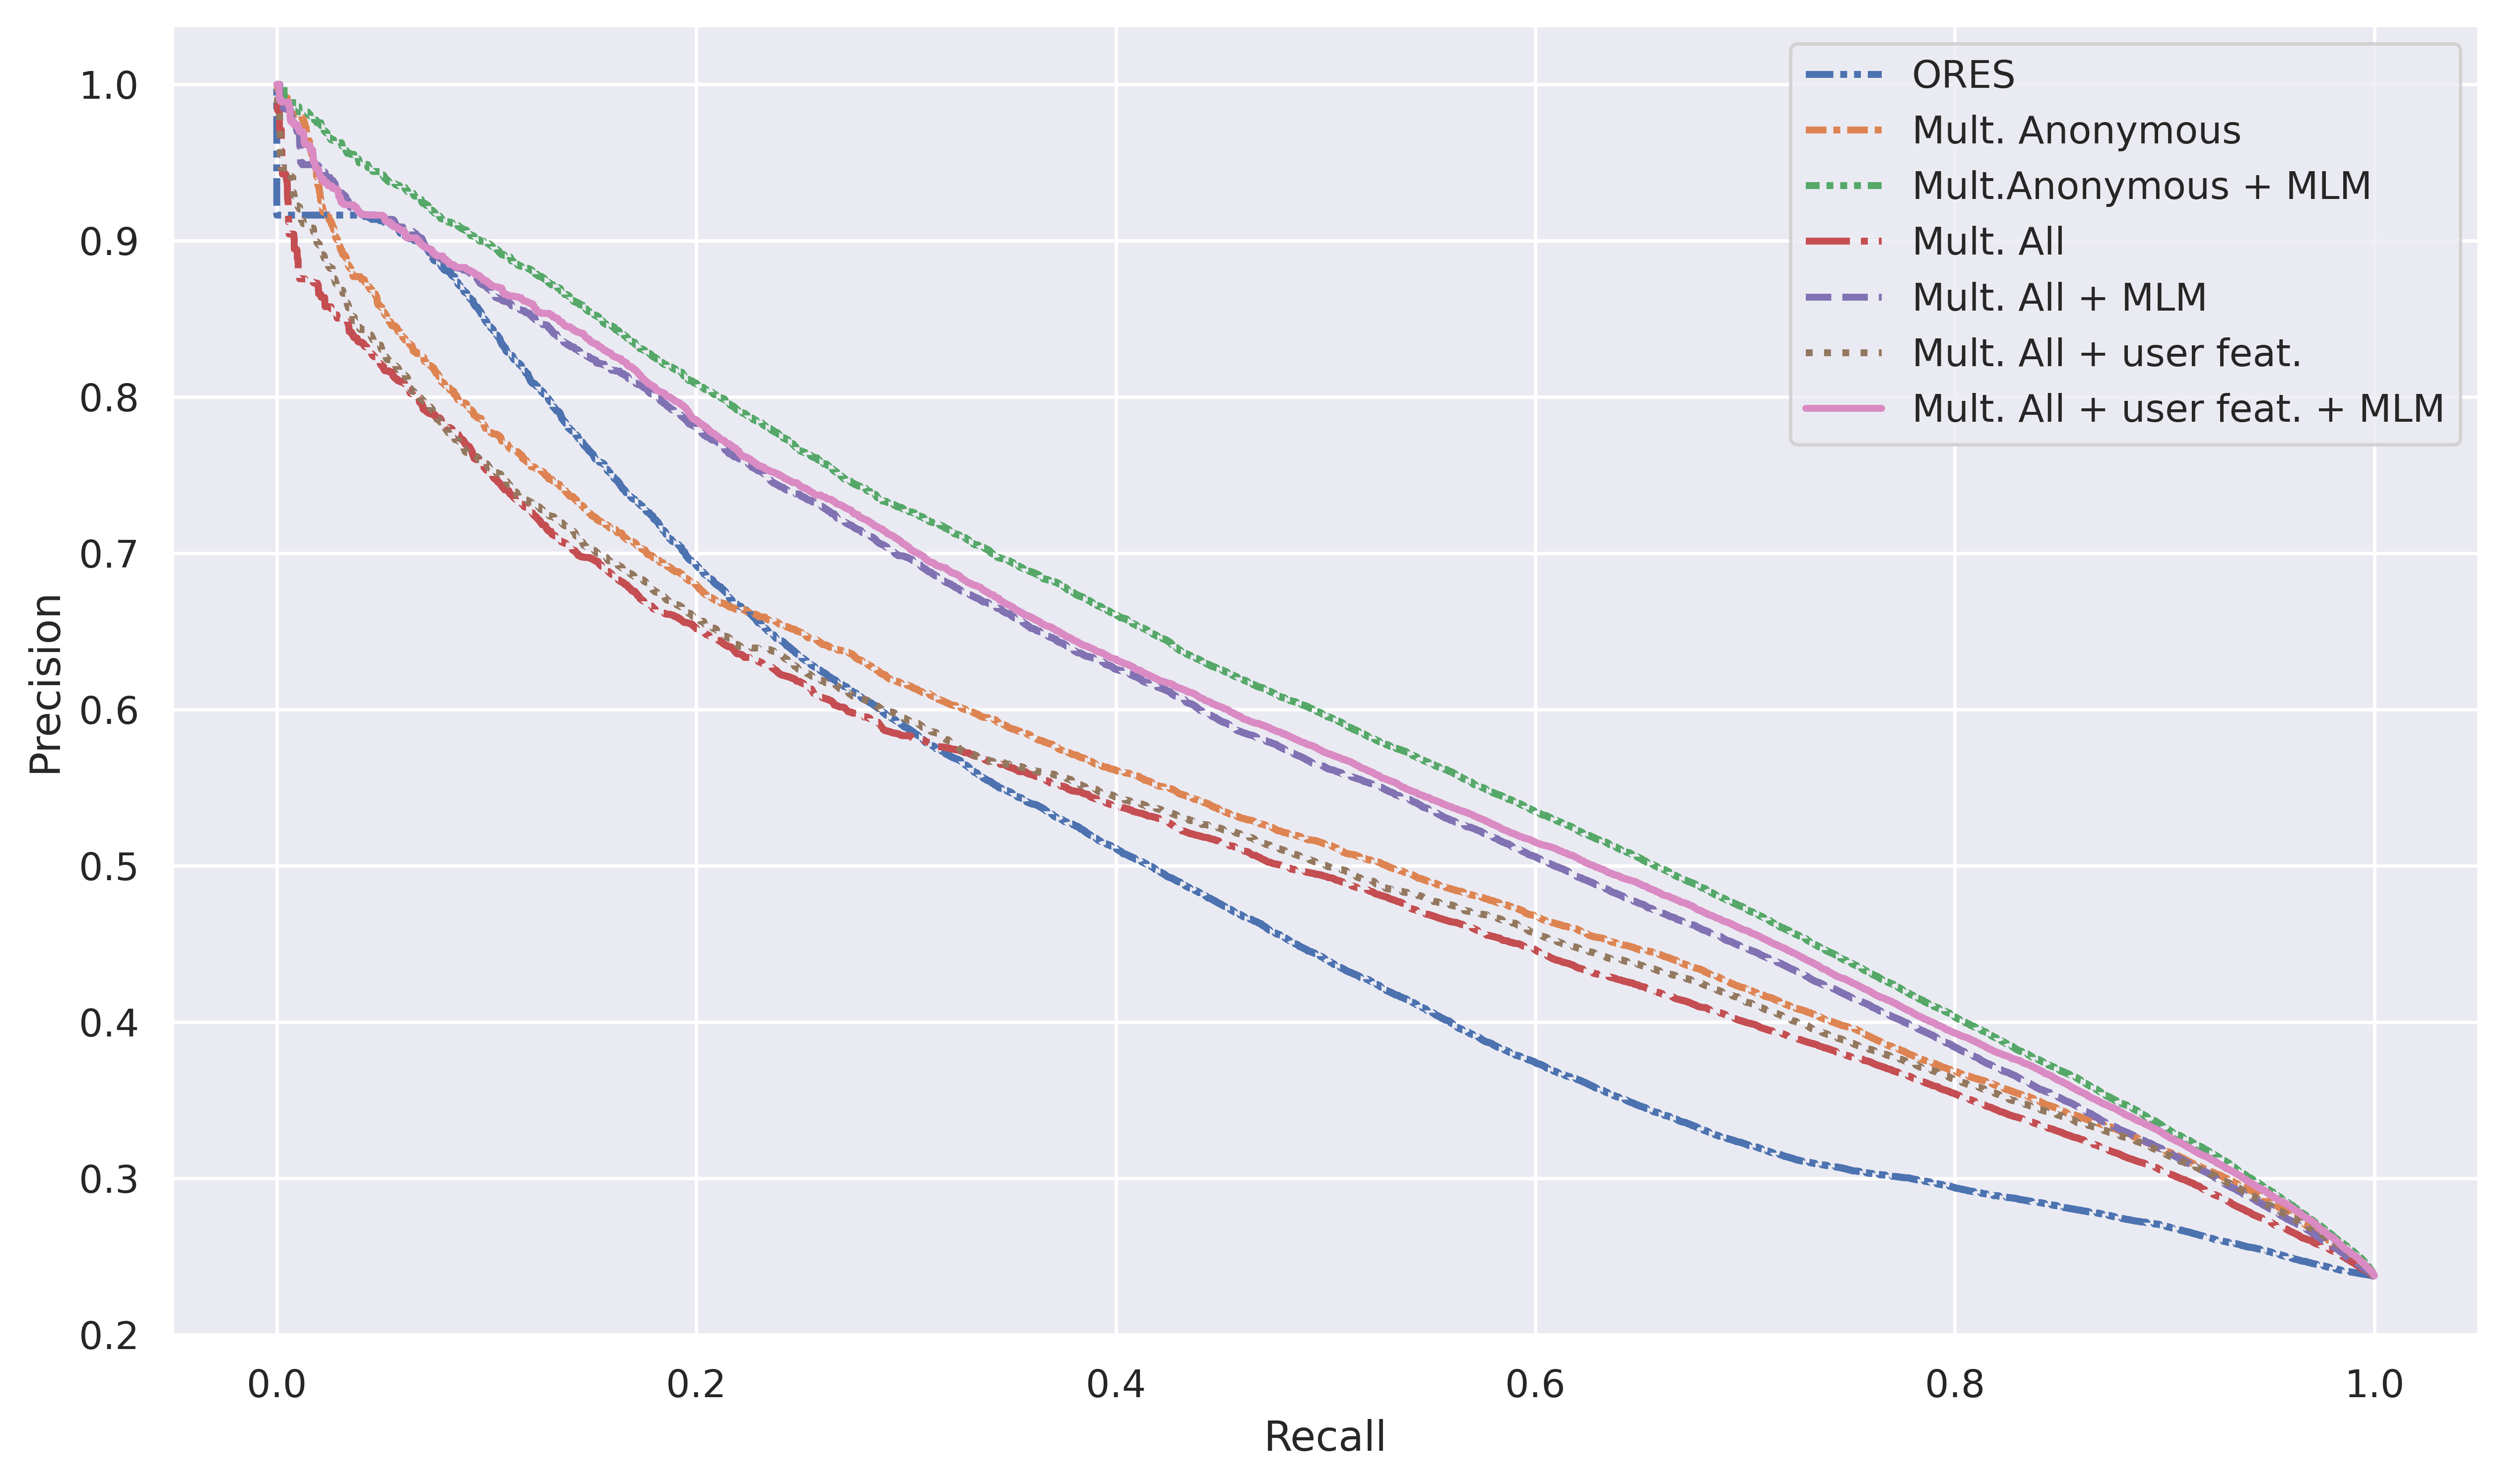

In [174]:
figure(figsize=(12, 7), dpi=500)
precision_recall_plot(test_df_balanced[test_df_balanced.is_anonymous == 1])

In [77]:
# revert rate:
countries_revert_rate = test_df.groupby("wiki_db")["revision_is_identity_reverted"].mean().to_dict()

# number of articles:
articles_df = pd.read_html("https://meta.wikimedia.org/wiki/List_of_Wikipedias")[0]
n_articles = {f"{cc}wiki": n for cc, n in zip(articles_df.Wiki, articles_df.Articles)}

# anon rate
countries_anon_rate = test_df.groupby("wiki_db")["is_anonymous"].mean().to_dict()

In [78]:
test_df_balanced

,wiki_db,event_comment,event_user_text_historical,event_user_seconds_since_previous_revision,revision_id,page_title,page_revision_count,revision_text_bytes_diff,revision_is_identity_reverted,event_timestamp,...,is_suppressredirect,ores_pred,model_pred,ml_pred,classifier_ml_anon_non_balanced_new_pred,classifier_ml_anon_non_balanced_mlm_new_pred,classifier_ml_all_non_balanced_new_pred,classifier_ml_all_non_balanced_mlm_new_pred,classifier_ml_all_non_balanced_user_features_new_pred,classifier_ml_all_non_balanced_user_features_mlm_new_pred
1241,lvwiki,/* Gada raksturojums pa mēnešiem */,DrewAir,61482.0,3642897,2022. gada laikapstākļi Latvijā,236,2883,0,2022-07-01 12:46:54.0,...,False,0.064643,False,0.183207,0.793565,0.595658,0.767729,0.258013,0.606200,0.183207
1242,lvwiki,NaN,MC2013,23991.0,3644717,Manhetenas projekts,99,30,0,2022-07-03 20:50:45.0,...,False,0.065648,False,0.021806,0.589894,0.305145,0.119167,0.069964,0.031749,0.021806
1243,lvwiki,/* Rezultāti */,Kleivas,143.0,3646513,Burāšana 1900. gada vasaras olimpiskajās spēlē...,10,116,0,2022-07-07 08:16:19.0,...,False,0.028898,False,0.006952,0.475092,0.234674,0.092051,0.027952,0.012829,0.006952
1244,lvwiki,NaN,Yungchains,193.0,3642562,XXXTentacion,23,18,0,2022-07-01 06:28:47.0,...,False,0.247820,False,0.362540,0.661230,0.649283,0.475430,0.528350,0.369380,0.362540
1245,lvwiki,Pievienota foto galerija,Gatons,140.0,3644945,Spīdzenieku pilskalns,4,197,0,2022-07-04 10:22:03.0,...,False,0.036062,False,0.073710,0.569747,0.512722,0.409678,0.492650,0.055987,0.073710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079260,enwiki,NaN,Debartolo2917,8.0,1096852079,Atlantic Championship,442,-1,0,2022-07-07 02:00:00.0,...,False,0.060910,False,0.212307,0.243543,0.225501,0.405880,0.379980,0.246468,0.212307
1079261,enwiki,NaN,100.17.18.142,NaN,1096862521,Power (name),81,56,0,2022-07-07 03:45:44.0,...,False,0.226608,True,0.752686,0.398690,0.413997,0.677574,0.679146,0.768216,0.752686
1079262,enwiki,Undid revision 1096868577 by [[Special:Contrib...,Oknazevad,35.0,1096868997,Diet Coke,2539,25,0,2022-07-07 04:46:20.0,...,False,0.019621,False,0.293358,0.491279,0.547331,0.534328,0.572352,0.293630,0.293358
1079263,enwiki,/* Carter Daniels{{anchor|Daniels}} */,NeoBatfreak,4000.0,1096968579,List of Final Destination characters,2921,2,0,2022-07-07 20:56:40.0,...,False,0.059861,False,0.271851,0.356380,0.216573,0.509844,0.539693,0.239274,0.271851


In [85]:
NAMES = [
    "ORES",
    "Mult. Anonymous", 
    "Mult.Anonymous + MLM",
    "Mult. All",
    "Mult. All + MLM",
    "Mult. All + user feat.",
    "Mult. All + user feat. + MLM",
]

metrics = []
for cc in test_df_balanced.wiki_db.unique():
    test_df_cc = test_df_balanced[test_df_balanced.wiki_db == cc]
    
    basic_info = {
        "wiki_db": cc, 
        "number_of_samples": len(test_df_cc),
        "revert_rate": countries_revert_rate[cc],
        "anonymous_rate": countries_anon_rate[cc],
        "number_of_articles": n_articles[cc],
    }
    
    for name, n in zip(model_names, NAMES):
        # cc_acc_anon_text = ((test_df_cc[f"{name}_pred"] > threshold).astype(int) == test_df_cc.revision_is_identity_reverted).mean()
        # pr = precision_at_recall(test_df_cc.revision_is_identity_reverted, test_df_cc[f"{name}_pred"])
        pr = roc_auc_score(test_df_cc.revision_is_identity_reverted, test_df_cc[f"{name}_pred"])
        
        metrics_dict = {"model": n, "metric": pr}
        metrics_dict.update(basic_info)
        metrics.append(metrics_dict)

In [86]:
# select only those that have more that 1K observations
metrics = pd.DataFrame(metrics)
metrics = metrics[metrics.number_of_samples > 10000]
metrics

,model,metric,wiki_db,number_of_samples,revert_rate,anonymous_rate,number_of_articles
49,ORES,0.883193,huwiki,12423,0.046278,0.099134,519466
50,Mult. Anonymous,0.770376,huwiki,12423,0.046278,0.099134,519466
51,Mult.Anonymous + MLM,0.767313,huwiki,12423,0.046278,0.099134,519466
52,Mult. All,0.799170,huwiki,12423,0.046278,0.099134,519466
53,Mult. All + MLM,0.814985,huwiki,12423,0.046278,0.099134,519466
...,...,...,...,...,...,...,...
184,Mult.Anonymous + MLM,0.733176,enwiki,98294,0.077510,0.193049,6611105
185,Mult. All,0.764987,enwiki,98294,0.077510,0.193049,6611105
186,Mult. All + MLM,0.788880,enwiki,98294,0.077510,0.193049,6611105
187,Mult. All + user feat.,0.840385,enwiki,98294,0.077510,0.193049,6611105


In [87]:
import altair as alt

axisY = alt.Axis(
    gridDash = [0,2,0], 
    grid=False,  
    ticks=False,
    labels=False,
)

bars = alt.Chart(metrics).mark_bar().encode(
    x=alt.X('metric:Q', scale=alt.Scale(zero=False), title="AUC"),
    y=alt.Y('model:O', axis=axisY, title=""),
    color='model:N',
    row=alt.Row('wiki_db:N', title="language", spacing=1.5, header=alt.Header(labelAngle=360, labelAlign="left"), sort=alt.EncodingSortField('metric', op='max', order='descending'))
).properties(
    width=280,
    height=20
)
bars

alt.Chart(...)

In [176]:
import altair as alt

axisY = alt.Axis(
    gridDash = [0,2,0], 
    grid=False,  
    ticks=False,
    labels=False,
)
metrics["language_code"] = metrics["wiki_db"].apply(lambda x: x[:2])
bars = alt.Chart(metrics).mark_bar().encode(
    x=alt.X('model:O', axis=axisY, title=""),
    y=alt.Y('metric:Q', scale=alt.Scale(zero=False), title="AUC"),
    color=alt.Color('model:N',legend=alt.Legend(
        orient='none',
        title=None,
        legendX=360, legendY=0, fillColor="white", columns=1,
        direction='vertical',
        titleAnchor='middle', )),
    column=alt.Column('language_code:N', title="language", spacing=3, 
                      header=alt.Header(labelAngle=360, labelAlign="center", labelPadding = -304, titlePadding=-315), 
                      sort=alt.EncodingSortField('metric', op='max', order='descending'))
).properties(
    width=21,
    height=280
)
bars

alt.Chart(...)

SpearmanrResult(correlation=-0.7157894736842104, pvalue=0.0005684691139054138)


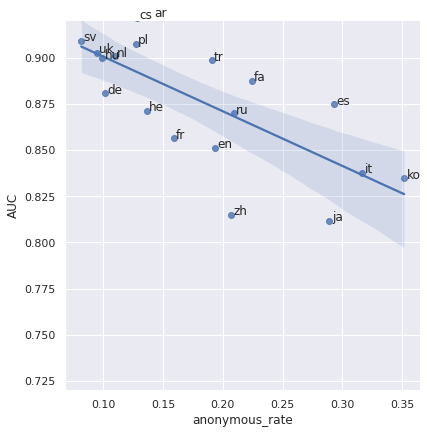

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
sns.set_theme()

# plt.figure(figsize=(10, 10), dpi=500)

data=metrics[metrics.model == "Mult. All + user feat. + MLM"]
# data=data[data.wiki_db != "eswiki"]

print(spearmanr(data.anonymous_rate, data.metric))

g = sns.lmplot(
    data=data,
    x="anonymous_rate", y="metric",
    height=6
)

# Use more informative axis labels than are provided by default
g.set_axis_labels("anonymous_rate", "AUC")
g.set(ylim=(0.72, 0.92))
# g.xlim((0.72, 0.92))

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.002, point['y'], str(point['val']))

label_point(data.anonymous_rate, data.metric, data.wiki_db.apply(lambda x: x[:2]), plt.gca())


plt.savefig('output_figure.png',dpi=600)

SpearmanrResult(correlation=-0.6210526315789473, pvalue=0.004541125258515691)


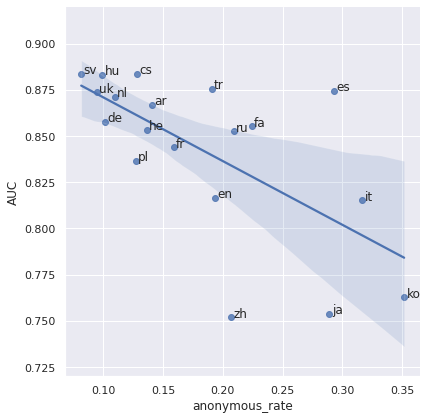

In [180]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

data=metrics[metrics.model == "ORES"]
# data=data[data.wiki_db != "eswiki"]
print(spearmanr(data.anonymous_rate, data.metric))


g = sns.lmplot(
    data=data,
    x="anonymous_rate", y="metric",
    height=6
)

# Use more informative axis labels than are provided by default
g.set_axis_labels("anonymous_rate", "AUC")
g.set(ylim=(0.72, 0.92))

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.002, point['y'], str(point['val']))

label_point(data.anonymous_rate, data.metric, data.wiki_db.apply(lambda x: x[:2]), plt.gca())

plt.savefig('output_figure_ores.png',dpi=600)